In [1]:
# execute this cell before you start

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras as keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(tf.__version__)
print(tf.keras.__version__)


2.12.0
2.12.0


# The CIFAR-10 dataset


Consider the data in  [`keras.datasets.cifar10`](https://www.tensorflow.org/datasets/catalog/cifar10) and train a network which reliably categorizes the data. 


This dataset has its own [Wikipedia page](https://en.wikipedia.org/wiki/CIFAR-10), and is often used as benchmark for new proposed methods. 



In [2]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(train_data,train_labels),(test_data,test_labels) = keras.datasets.cifar10.load_data()


from ipywidgets import interact

@interact(k=(0, len(train_data)-1))
def myplot(k):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(labels[train_labels[k][0]])
    ax.imshow(train_data[k])


interactive(children=(IntSlider(value=24999, description='k', max=49999), Output()), _dom_classes=('widget-int…

## Check data
Since we access the cifar10 dataset from the keras database, then we divide the dataset into a test set and a training set, the main purpose of this is to train the network with the training data, and then test it with the test data Whether the training was successful.

In [3]:
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

(train_data,train_labels),(test_data,test_labels) = keras.datasets.cifar10.load_data()


from ipywidgets import interact

@interact(k=(0, len(train_data)-1))
def myplot(k):
    fig, ax = plt.subplots(figsize=(6, 6))
    ax.set_title(labels[train_labels[k][0]])
    ax.imshow(train_data[k])

interactive(children=(IntSlider(value=24999, description='k', max=49999), Output()), _dom_classes=('widget-int…

Check the type and size of the initial dataset in order to data preprocessing:

In [4]:
train_data.shape, type(train_data)

((50000, 32, 32, 3), numpy.ndarray)

In [5]:
train_labels.shape, type(train_labels)

((50000, 1), numpy.ndarray)

In [6]:
test_data.shape, type(test_data)

((10000, 32, 32, 3), numpy.ndarray)

In [7]:
test_labels.shape, type(test_labels)

((10000, 1), numpy.ndarray)

## Data preprocessing
As we can see here 5000 images are used as training set and 1000 images are used as test set in cifar10 dataset, and all images are 32×23 in size and have three color channels, each image is have corresponding labels. With a basic understanding of the data we have, the next step is to normalize the data by dividing the pixel values of the image into a range of 0 and 1 by dividing by 255.

In [8]:
train_data = train_data / 255.0

test_data = test_data / 255.0

- I want to use the flatten layer in the model I designed, so I use the flatten function to make the multi-dimensional input one-dimensional. The advantage of this is to reduce the use of parameters and avoid overfitting.
- The reason for using the flatten function is that the fully connected layer cannot be directly connected to the convolutional layer. The data of the Convolution layer needs to be flattened, and then the Dense layer can be added directly.

In [9]:
train_labels, test_labels = train_labels.flatten(), test_labels.flatten()

 Actually in data preprocessing, I do regularization and use flatten function to process the input data. Then, I built a CNN-based model to process this data.

## Build the model

After data preprocessing, I am in a position to build a model. 
- First, I used a 3×3 convolution kernel for convolution, and set 8 units to divide the input into 8 types, and then used the activation function relu for classification. Besides, the input boundary data will be reduced during the convolution process, padding='same' means padding the boundary data with 0 to keep the convolved data in the same shape and the input shape should be (32,32,3). 

- The same as before, I use the same structure for the next few layers, the only difference is that I increase the number of units to make the data have more classification results in hidden layers.

- Then I used the Flatten layer to expand the array to convert the original 3 lines The array becomes 1 row, namely, compress the data of (height,width,channel) into a one-dimensional array of length height × width × channel.

-    In addition, it can be clearly seen that it is a multi-classification problem, in this case, we need the model to output 10 outputs as results for different labels in dense layers, so I use the softmax layer for output.

In [10]:
model = keras.Sequential()
model.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPooling2D((2, 2)))

model.add(layers.Flatten())
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 4, 4, 32)         0

On the model's optimizer, I chose the adam algorithm with sparse cross-entropy as the loss function.

- Why use adam algorithm?  

Adaptive moment estimation can achieve good result.

- Why use a sparse cross-entropy function instead of a cross-entropy function?  

This is because I am not using one-hot encoding, the data is numerically encoded so use the sparse cross entropy function.

In [11]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

When I start to train the model, I set the batch size to 64, this is because I want to increase the utilization of the gpu, reduce the time to process the data and reduce the training oscillation. In order to consider the time to train the data, I set the number of iterations to 10. At the same time, I use the test set in the data as the validation set and split the test in a ratio of 8 to 2.

In [12]:
history = model.fit(train_data, train_labels, batch_size=64, epochs=10, validation_split=.2, 
                    validation_data=(test_data, test_labels), verbose=1)

Epoch 1/10
782/782 [==============================] - 22s 24ms/step - loss: 1.6976 - acc: 0.3807 - val_loss: 1.4414 - val_acc: 0.4763
Epoch 2/10
782/782 [==============================] - 17s 22ms/step - loss: 1.3761 - acc: 0.5064 - val_loss: 1.3034 - val_acc: 0.5376
Epoch 3/10
782/782 [==============================] - 18s 23ms/step - loss: 1.2564 - acc: 0.5522 - val_loss: 1.2115 - val_acc: 0.5716
Epoch 4/10
782/782 [==============================] - 17s 22ms/step - loss: 1.1824 - acc: 0.5812 - val_loss: 1.1626 - val_acc: 0.5895
Epoch 5/10
782/782 [==============================] - 16s 20ms/step - loss: 1.1248 - acc: 0.6047 - val_loss: 1.1124 - val_acc: 0.6070
Epoch 6/10
782/782 [==============================] - 17s 22ms/step - loss: 1.0730 - acc: 0.6218 - val_loss: 1.0804 - val_acc: 0.6201
Epoch 7/10
782/782 [==============================] - 17s 22ms/step - loss: 1.0324 - acc: 0.6365 - val_loss: 1.0723 - val_acc: 0.6270
Epoch 8/10
782/782 [==============================] - 18s 23ms

By using model.evaluate, we can see the accuracy of this model.

In [13]:
model.evaluate(test_data, test_labels, verbose=0)

[1.037697434425354, 0.6378999948501587]

In [14]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

However, in the performance analysis of the model, we also need to consider the loss curve and the accuracy curve to judge whether the model is underfitting, overfitting or good fit.

- Underfitting means that the model is unable to find regularities in the data. In other words, it means that the model cannot learn anything useful from the data, and the model will perform poorly on both the training set and the test set.
- Overfitting means that the model looks for the rules in the data too precisely so that some noises are also regarded as the rules in the data. The model will perform well in the training set, but it will not perform well in the test set, namely, the generalization ability of the model is poor.


- Why underfitting?  

In the model, the model parameters are too few or the structure is too simple

- Solution for underfitting  

add more training data
Increase the network structure or increase the parameters
lower the regularization constraint


- Why overfitting?  

The amount of data is too small
In the model, there are too many model parameters or the structure is too complex

- Solution for overfitting  

add more training data
Reduce the network structure or increase the parameters
Add regularization constraints, use L1 regularization, L2 regularization or add dropout layers and batch regularization layers to the model

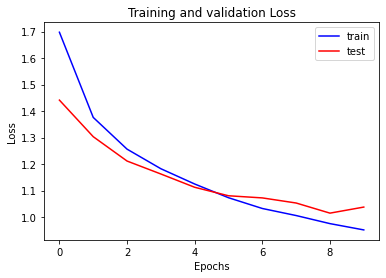

In [15]:
plt.title('Training and validation Loss')
plt.plot(history.history['loss'], color='blue', label='train')
plt.plot(history.history['val_loss'], color='red', label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

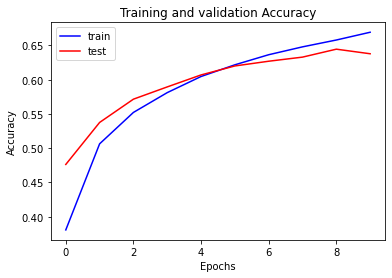

In [16]:
plt.title('Training and validation Accuracy')
plt.plot(history.history['acc'], color='blue', label='train')
plt.plot(history.history['val_acc'], color='red', label='test')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

Through the loss curve and acc curve, we can see that in the first model, the loss curve of the test set as the validation set is larger than the training set as the number of iterations increases, so it can be judged that the model is overfitting, so in my In the next model, I added a dropout layer to reduce overfitting.

## Dropout layer

The difference between this model and the first model is that a dropout layer is added. 0.1 in the dropout layer means that the output is discarded according to the probability of 0.1 to reduce model overfitting.

In [17]:
model2 = keras.Sequential()
model2.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model2.add(layers.MaxPooling2D((2, 2)))

model2.add(layers.Flatten())
model2.add(layers.Dropout(0.1))
model2.add(layers.Dense(32, activation='relu'))
model2.add(layers.Dense(10, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_3 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 8, 8, 32)          4640      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 4, 4, 32)        

I didn't change the optimizer and loss function because I would like to just compare the effect of adding dropout layers on the model.

In [18]:
model2.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

In [19]:
history2 = model2.fit(train_data, train_labels, batch_size=64, epochs=10, validation_split=.2, 
                      validation_data=(test_data, test_labels), verbose=1)

Epoch 1/10
782/782 [==============================] - 17s 21ms/step - loss: 1.6991 - acc: 0.3796 - val_loss: 1.4293 - val_acc: 0.4904
Epoch 2/10
782/782 [==============================] - 18s 23ms/step - loss: 1.4040 - acc: 0.4969 - val_loss: 1.2976 - val_acc: 0.5385
Epoch 3/10
782/782 [==============================] - 18s 23ms/step - loss: 1.2828 - acc: 0.5439 - val_loss: 1.2360 - val_acc: 0.5587
Epoch 4/10
782/782 [==============================] - 18s 23ms/step - loss: 1.1916 - acc: 0.5804 - val_loss: 1.1355 - val_acc: 0.5996
Epoch 5/10
782/782 [==============================] - 17s 21ms/step - loss: 1.1341 - acc: 0.6005 - val_loss: 1.1029 - val_acc: 0.6132
Epoch 6/10
782/782 [==============================] - 20s 25ms/step - loss: 1.0899 - acc: 0.6164 - val_loss: 1.0583 - val_acc: 0.6308
Epoch 7/10
782/782 [==============================] - 17s 22ms/step - loss: 1.0567 - acc: 0.6307 - val_loss: 1.0445 - val_acc: 0.6383
Epoch 8/10
782/782 [==============================] - 17s 22ms

The same as the first model, by using model.evaluate, we can see the accuracy of this model.

In [20]:
model2.evaluate(test_data, test_labels, verbose=0)

[0.9993571043014526, 0.6549999713897705]

In [21]:
history_dict2 = history2.history
history_dict2.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

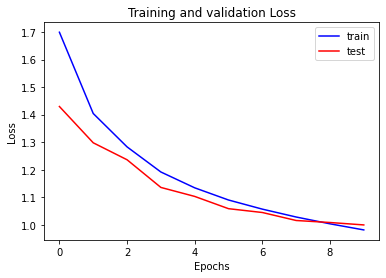

In [22]:
plt.title('Training and validation Loss')
plt.plot(history2.history['loss'], color='blue', label='train')
plt.plot(history2.history['val_loss'], color='red', label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

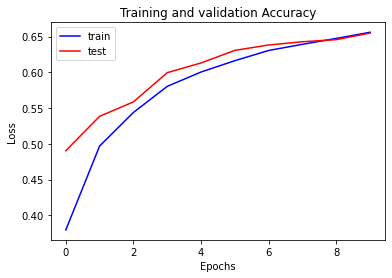

In [23]:
plt.title('Training and validation Accuracy')
plt.plot(history2.history['acc'], color='blue', label='train')
plt.plot(history2.history['val_acc'], color='red', label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

From the second model we can see that the degree of overfitting is reduced after using dropout regularization, in model2 we are able to get a good fit.

It is worth noting that the dropout layer I use means discarding some rules found by the model, so the accuracy of this model for identifying data may decrease.

## Batch Normalization

In my third model I used BatchNormalization as one of the regularization methods. The difference between it and the dropout layer is that the dropout layer is usually added in the fully connected layer. BatchNormalization can be added during convolution to make the model more stable.  

As we can see here, I add many BatchNormalization layers after convolution, pooling and flatten

BatchNormalization can reduce training time and improve accuracy by readjusting the distribution of data so that the output of each layer obeys a normal distribution with a mean of 0 and a variance of 1.

In [24]:
from keras.layers import BatchNormalization
model3 = keras.Sequential()
model3.add(layers.Conv2D(8, (3, 3), activation='relu', padding='same', input_shape=(32, 32, 3)))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(BatchNormalization())

model3.add(layers.Conv2D(16, (3, 3), activation='relu', padding='same'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(BatchNormalization())

model3.add(layers.Conv2D(32, (3, 3), activation='relu', padding='same'))
model3.add(layers.MaxPooling2D((2, 2)))
model3.add(BatchNormalization())

model3.add(layers.Flatten())
model3.add(layers.Dense(32, activation='relu'))
model3.add(layers.Dense(10, activation='softmax'))

model3.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['acc'])

model3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 32, 32, 8)         224       
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 16, 16, 8)        0         
 2D)                                                             
                                                                 
 batch_normalization (BatchN  (None, 16, 16, 8)        32        
 ormalization)                                                   
                                                                 
 conv2d_7 (Conv2D)           (None, 16, 16, 16)        1168      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 8, 8, 16)         0         
 2D)                                                             
                                                      

In [25]:
history3 = model3.fit(train_data, train_labels, batch_size=64, epochs=10, validation_split=.2, 
                      validation_data=(test_data, test_labels), verbose=1)

Epoch 1/10
782/782 [==============================] - 20s 23ms/step - loss: 1.4898 - acc: 0.4702 - val_loss: 1.3074 - val_acc: 0.5357
Epoch 2/10
782/782 [==============================] - 18s 23ms/step - loss: 1.1315 - acc: 0.6018 - val_loss: 1.3430 - val_acc: 0.5299
Epoch 3/10
782/782 [==============================] - 18s 22ms/step - loss: 1.0034 - acc: 0.6487 - val_loss: 1.0628 - val_acc: 0.6225
Epoch 4/10
782/782 [==============================] - 18s 23ms/step - loss: 0.9207 - acc: 0.6741 - val_loss: 1.2473 - val_acc: 0.5767
Epoch 5/10
782/782 [==============================] - 18s 23ms/step - loss: 0.8634 - acc: 0.6949 - val_loss: 0.9670 - val_acc: 0.6643
Epoch 6/10
782/782 [==============================] - 20s 25ms/step - loss: 0.8229 - acc: 0.7100 - val_loss: 0.9805 - val_acc: 0.6617
Epoch 7/10
782/782 [==============================] - 19s 24ms/step - loss: 0.7855 - acc: 0.7232 - val_loss: 1.0413 - val_acc: 0.6487
Epoch 8/10
782/782 [==============================] - 20s 25ms

Normally, we can find that using the BatchNormalization layer can further improve the accuracy of the model.

In [26]:
model3.evaluate(test_data, test_labels, verbose=0)

[0.9813050627708435, 0.6696000099182129]

In [27]:
history_dict3 = history3.history
history_dict3.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

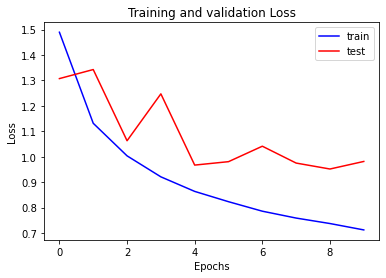

In [28]:
plt.title('Training and validation Loss')
plt.plot(history3.history['loss'], color='blue', label='train')
plt.plot(history3.history['val_loss'], color='red', label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

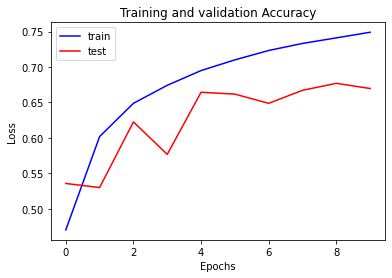

In [30]:
plt.title('Training and validation Accuracy')
plt.plot(history3.history['acc'], color='blue', label='train')
plt.plot(history3.history['val_acc'], color='red', label='test')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# CA
From the training results of the third model, Why did I use BatchNormalization regularization in model 3 but overfit?  

This is because I added a lot of BatchNormalization to the model to make the model more complex. At the same time, when using Batch Normalization for training, because mean and var are constantly recalculated with the model training, when the Batch Size is too small, the model will become more difficult to fit, and the Loss curve will oscillate.

Therefore, when using Batch Normalization for training, we also need to consider the complexity of the model and the size of the batch size


- What increases computing time?  

The complexity of the structure of the model, the number of units of the model, the number of data, the number of iterations.

- What increases accuracy?  

Get more data, add more layers in the model to make the model deeper, increase the number of trainings, change the image too small or reduce the color channel, change the size of the convolution kernel, consider different parameters such as learning rate, activation function, Loss functions, optimizers or reduce regularization.

### Conclusion: 

In question 1, I built three different models. In the first model I built, I found that my model was overfitting through the loss curve and acc curve, so I used the regularization method of dropout layer to reduce overfitting. It can be seen that the degree of overfitting in the second model is reduced, but there is still overfitting, so I continue to use the BatchNormalization layer to reduce overfitting and improve the accuracy of the model, and finally get a better performance than the first two models. 

The situation of overfitting may be that the structure of my first model setting is complicated, or there is not enough data for the model to learn. In fact, I can also use data augmentation to increase the amount of data or I can change the parameters in the model such as the learning rate to improve the accuracy of the model.